In [20]:
import os, sys, email,re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

## What do the emails say?

In [21]:
# emails_df = pd.read_csv('./emails.csv', nrows=20000)
df = pd.read_csv('./emaildataset.csv')
print(df.shape)
df.head()

(301, 5)


,From,To,Subject,Body,Class(output)
0,NaN,NaN,NaN,NaN,NaN
1,Morgan@JPMorgan.com,Esabella@CitiBankSingapore.com,168717Waiting for amount pending,The trasaction 168717 is taking too long to be...,B
2,Morgan@HSBC.com,Meghan@CitiBankLondon.com,413891Transaction is in progress,Payment 413891 will be completed within two days,B
3,Morgan@CitiBankLondon.com,Anthony@CitiBankLondon.com,988795urgent: need transaction details,988795 sdjvbksd,D
4,Morgan@CitiBankLondon.com,Dipesh@CitiBankLondon.com,613137Transaction Failed,"Lack of funds, check no. 613137 has been bounced.",A


In [22]:
df = df.loc[1:]
df.reset_index(inplace=True)

In [47]:
# Parse datetime
df['Date'] = np.random.choice(pd.date_range('2019-01-01', '2020-06-01'), len(df))
df.dtypes

From                     object
To                       object
Subject                  object
Body                     object
Class(output)            object
Date             datetime64[ns]
dtype: object

In [48]:
df.head()

,From,To,Subject,Body,Class(output),Date
0,Morgan@JPMorgan.com,Esabella@CitiBankSingapore.com,168717Waiting for amount pending,The trasaction 168717 is taking too long to be...,B,2020-02-01
1,Morgan@HSBC.com,Meghan@CitiBankLondon.com,413891Transaction is in progress,Payment 413891 will be completed within two days,B,2019-06-25
2,Morgan@CitiBankLondon.com,Anthony@CitiBankLondon.com,988795urgent: need transaction details,988795 sdjvbksd,D,2019-03-09
3,Morgan@CitiBankLondon.com,Dipesh@CitiBankLondon.com,613137Transaction Failed,"Lack of funds, check no. 613137 has been bounced.",A,2019-11-08
4,Spike@BNYMellon.com,Meghan@CitiBankNewYork.com,Update on Acc 131265,The trasaction 131265 is taking too long to be...,B,2020-01-17


In [24]:
df.drop(['index'], axis=1, inplace=True)

In [25]:
print(df.loc[1]["Body"])

Payment 413891 will be completed within two days


In [40]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent","thanks", "regards", "hi", "hello", "thank you"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    amount = " ".join([i for i in text.lower().split() if i.isdigit()])
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized, amount

In [41]:
#sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]

for text in df['Body']:
    text_clean.append(clean(text)[0].split())
    amount = clean(text)[1]

amount

''

In [42]:
text_clean

[['trasaction', 'taking', 'long', 'completed'],
 ['payment', 'completed', 'within', 'two', 'day'],
 ['sdjvbksd'],
 ['lack', 'fund', 'check', 'bounced'],
 ['trasaction', 'taking', 'long', 'completed'],
 ['transaction', 'recieved'],
 ['trasaction', 'taking', 'long', 'completed'],
 ['payment', 'completed', 'within', 'two', 'day'],
 ['full', 'payment', 'update', 'successfully', 'recieved'],
 ['lack', 'fund', 'check', 'bounced'],
 ['trasaction', 'taking', 'long', 'completed'],
 ['payment', 'completed', 'within', 'two', 'day'],
 ['due',
  'server',
  'overflow',
  'transaction',
  'completed',
  'within',
  'seven',
  'ten',
  'working',
  'day'],
 ['trasaction', 'taking', 'long', 'completed'],
 ['full', 'payment', 'update', 'successfully', 'recieved'],
 ['due', 'unknown', 'technical', 'error', 'transaction', 'cancalled'],
 ['aaaaa', 'qqqqqq'],
 ['due', 'unknown', 'technical', 'error', 'transaction', 'cancalled'],
 ['trasaction', 'taking', 'long', 'completed'],
 ['due',
  'server',
  'overfl

In [43]:
amount

''

In [44]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

In [46]:
text_term_matrix

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(13, 1), (14, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(5, 1), (13, 1), (15, 1), (16, 1), (17, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(0, 1),
  (4, 1),
  (7, 1),
  (14, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(5, 1), (13, 1), (15, 1), (16, 1), (17, 1)],
 [(14, 1), (18, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(28, 1), (29, 1)],
 [(14, 1), (18, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1),
  (4, 1),
  (7, 1),
  (14, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1)],
 [(8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1)],
 [(0, 1),
  (4, 1),
  (7, 1),
  (14, 1),
  (18, 1),
  (19, 

In [10]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=4, id2word = dictionary, passes=30)

In [11]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    #text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

In [12]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()

In [13]:
N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [14]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

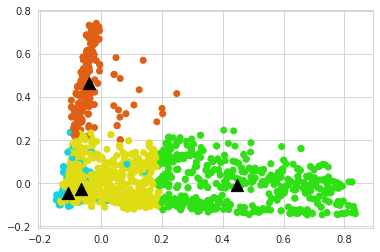

In [15]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [16]:
#print(ldamodel.print_topics(num_topics=4, num_words=10))
print([(0, '0.012*"enron" + 0.012*"deal" + 0.010*"agreement" + 0.008*"change" + 0.008*"contract" + 0.008*"corp" + 0.007*"fax" + 0.005*"houston" + 0.005*"date" + 0.005*"america"'), (1, '0.005*"message" + 0.005*"origin" + 0.004*"pleas" + 0.004*"email" + 0.004*"thank" + 0.003*"attach" + 0.003*"file" + 0.003*"copy" + 0.003*"inform" + 0.003*"receive"'), (2, '0.015*"thank" + 0.008*"call" + 0.005*"time" + 0.004*"meet" + 0.003*"look" + 0.003*"week" + 0.003*"day" + 0.003*"lunch" + 0.003*"talk" + 0.003*"hello"'), (3, '0.016*"market" + 0.009*"gas" + 0.008*"price" + 0.005*"power" + 0.004*"company" + 0.004*"energy" + 0.003*"business" + 0.003*"service" + 0.003*"manage" + 0.003*"fare"')])

[(0, '0.012*"enron" + 0.012*"deal" + 0.010*"agreement" + 0.008*"change" + 0.008*"contract" + 0.008*"corp" + 0.007*"fax" + 0.005*"houston" + 0.005*"date" + 0.005*"america"'), (1, '0.005*"message" + 0.005*"origin" + 0.004*"pleas" + 0.004*"email" + 0.004*"thank" + 0.003*"attach" + 0.003*"file" + 0.003*"copy" + 0.003*"inform" + 0.003*"receive"'), (2, '0.015*"thank" + 0.008*"call" + 0.005*"time" + 0.004*"meet" + 0.003*"look" + 0.003*"week" + 0.003*"day" + 0.003*"lunch" + 0.003*"talk" + 0.003*"hello"'), (3, '0.016*"market" + 0.009*"gas" + 0.008*"price" + 0.005*"power" + 0.004*"company" + 0.004*"energy" + 0.003*"business" + 0.003*"service" + 0.003*"manage" + 0.003*"fare"')]


In [ ]:
model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
# finding most similar word with group of words
# part - A
>>> model.wv.most_similar(positive=['woman', 'king'], negative=['man'])
[('queen', 0.50882536), ...]
# Part - B
>>> model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
[('queen', 0.71382287), ...]
# Part - C
>>> model.wv.doesnt_match("breakfast cereal dinner lunch".split())
'cereal'
# Part - D
>>> model.wv.most_similar(positive=['woman', 'king'], topn=10)
<list of 10 most common words>
# Note: this model heavily depends on data quality
# Part - D is the exact answer, written in python using gensim library

In [ ]:
from gensim.models import Word2Vec

gmodel=Word2Vec.load_word2vec_format(fname)
ms=gmodel.most_similar('good',10)
for x in ms:
    print x[0],x[1]